## Load required libraries

In [1]:
# Needed for OutOfMemoryError: Java heap space 
library(rJava)
.jinit(parameters="-Xmx4g")
# If there are more memory problems, invoke gc() after the POS tagging

library(NLP) 
library(openNLP) 
library(openNLPmodels.en)
library(tm)
library(stringr)

## Auxiliary Functions

In [2]:
# Returns annotations for the text document: word, sentence, part-of-speech, and Penn Treebank parse annotations

getAnnotationsFromDocument = function(doc){
  x=as.String(doc)
  sent_token_annotator <- Maxent_Sent_Token_Annotator()
  word_token_annotator <- Maxent_Word_Token_Annotator()
  pos_tag_annotator <- Maxent_POS_Tag_Annotator()
  y1 <- annotate(x, list(sent_token_annotator, word_token_annotator))
  y2 <- annotate(x, pos_tag_annotator, y1)
  # parse_annotator <- Parse_Annotator()
  # y3 <- annotate(x, parse_annotator, y2)
  return(y2)  
} 

# Returns the text document merged with the annotations

getAnnotatedMergedDocument = function(doc,annotations){
  x=as.String(doc)
  y2w <- subset(annotations, type == "word")
  tags <- sapply(y2w$features, '[[', "POS")
  r1 <- sprintf("%s/%s", x[y2w], tags)
  r2 <- paste(r1, collapse = " ")
  return(r2)  
} 

# Returns the text document along with its annotations in an AnnotatedPlainTextDocument

getAnnotatedPlainTextDocument = function(doc,annotations){
  x=as.String(doc)
  a = AnnotatedPlainTextDocument(x,annotations)
  return(a)  
} 

# detectPatternOnDocument returns the pattern detected on an AnnotatedPlainTextDocument

detectPatternOnDocument <- function(doc, pattern) {
  x=as.String(doc)
  res=str_match(x,pattern)
  
  if (length(res)==1){
    return (res)
  } else {
    if (all(is.na(res[,2:length(res)])))
      return (NA)
    else {
      ret=list()
      for (i in 2:length(res)){
        ret = paste(ret,res[i])
      }
      return(ret)
    }
  }
}

# detectPatternOnDocumentWithContext returns the pattern detected on an AnnotatedPlainTextDocument with some context.

detectPatternOnDocumentWithContext <- function(doc, pattern) {
  txt=as.String(doc)
  number=50
  coord=str_locate(txt,pattern)
  res3=substr(txt,coord[1]-number,coord[2]+number)
  return (res3)
}

# detectPatternsInCorpus returns a data frame with all the patterns detected in a corpus.

detectPatternsInCorpus = function(corpus, patterns){
  vallEntities <- data.frame(matrix(NA, ncol = length(patterns)+1, 
                                    nrow = length(corpus)))
  names(vallEntities) <- c("File",patterns)
  for (i in 1:length(patterns)) {
    vallEntities[,i+1]=unlist(lapply(corpus, detectPatternOnDocument, 
                                     pattern=patterns[i]))
  }
  for (i in 1:length(corpus)) {
    vallEntities$File[i]=meta(corpus[[i]])$id
  }
  return (vallEntities)  
}

# detectPatternsInTaggedCorpus returns a data frame with all the patterns detected in an annotated corpus.

detectPatternsInTaggedCorpus = function(corpus, taggedCorpus, patterns){
  vallEntities <- data.frame(matrix(NA, ncol = length(patterns)+1, 
                                    nrow = length(corpus)))
  names(vallEntities) <- c("File",patterns)
  for (i in 1:length(patterns)) {
    vallEntities[,i+1]=unlist(lapply(taggedCorpus, detectPatternOnDocument, 
                                     pattern=patterns[i]))
  }
  for (i in 1:length(corpus)) {
    vallEntities$File[i]=meta(corpus[[i]])$id
  }
  return (vallEntities)  
}

# countMatchesPerColumn returns the number of matches per pattern/column. Counts the number of columns with non-NA values for each pattern.

countMatchesPerColumn = function (df) {
  entityCountPerPattern <- data.frame(matrix(NA, ncol = 2, 
                                             nrow = length(names(df))-1))
  names(entityCountPerPattern) <- c("Entity","Count")
  
  for (i in 2:length(names(df))) {
    entityCountPerPattern$Entity[i-1] = names(df)[i]
    entityCountPerPattern$Count[i-1] = nrow(subset(df, !is.na(df[i])))
  }
  return (entityCountPerPattern)
}

# countMatchesPerRow returns the number of entities per file/row. Counts the number of rows with non-NA values for each file.

countMatchesPerRow = function (df) {
  entityCountPerFile <- data.frame(matrix(NA, ncol = 2, nrow = nrow(df)))
  names(entityCountPerFile) <- c("File","Count")
  
  for (i in 1:nrow(df)) {
    entityCountPerFile$File[i] = df$File[i]
    entityCountPerFile$Count[i] = length(Filter(Negate(is.na),df[i,2:length(df[i,])]))
  }
  return (entityCountPerFile[entityCountPerFile[2]!=0,])
}

# printMatchesPerPattern prints the matches found per pattern.

printMatchesPerPattern = function (patterns, matches) {
  for (i in 1:length(patterns)){
    print(paste("PATTERN: ",patterns[i]))
    strings = matches[,i+1][!is.na(unlist(matches[,i+1]))]
    print(strings)
    print(" ") 
  }
}

# mergeAllMatchesInLists returns a data frame with all the files and their matches in a single list per file.

mergeAllMatchesInLists = function (df) {
  matchesPerFile = rep(list(list()), nrow(df))
  
  for (i in 1:nrow(df)) {    
    matches=as.list(unname(unlist(Filter(Negate(is.na),df[i,2:length(df[i,])]))))
    matchesPerFile[[i]]=append(matchesPerFile[[i]],matches)
  }
  
  files = df[,1]
  matches = matchesPerFile
  
  allMatches<- data.frame(matrix(NA, ncol = 2, nrow = nrow(df)))
  names(allMatches) <- c("Files","Matches")
  
  allMatches$Files=files
  allMatches$Matches=matches
  
  return (allMatches)
}

# mergeGoldStandardInLists returns a data frame with all the files and the gold standard matches in a single list per file.

mergeGoldStandardInLists = function (df) {
  matchesPerFile = rep(list(list()), nrow(df))
  
  for (i in 1:nrow(df)) {    
    matches=as.list(unlist(Filter(Negate(is.na),df[i,2:length(df)])))
    matchesPerFile[[i]]=append(matchesPerFile[[i]],matches)
  }
  
  files = df[,1]
  matches = matchesPerFile
  
  allMatches<- data.frame(matrix(NA, ncol = 2, nrow = nrow(df)))
  names(allMatches) <- c("Files","Matches")
  
  allMatches$Files=files
  allMatches$Matches=matches
  
  return (allMatches)
}

# calculateMetrics calculates precision, recall and f-measure according to a gold standard.

calculateMetrics = function (matches, matches.gs) {
  
  metrics<- data.frame(matrix(NA, ncol = 3, nrow = 1))
  names(metrics) <- c("Precision","Recall","Fmeasure")
  
  numCorrect = 0
  allAnswers = 0
  possibleAnswers = 0
  
  for (i in 1:nrow(matches)) {    
    if (length(matches.gs$Matches[[i]])!=0) {
      l = str_trim(unlist(matches[i,2]))
      l.gs = unname(unlist(matches.gs[i,2]))
      intersection = intersect(l, l.gs)
      numCorrect = numCorrect + length(intersect(l, l.gs))
      allAnswers = allAnswers + length (l)
      possibleAnswers = possibleAnswers + length(l.gs)    
    }
  }
  
  metrics$Precision = numCorrect / allAnswers
  metrics$Recall = numCorrect / possibleAnswers
  
  beta = 1
  metrics$Fmeasure= ((sqrt(beta)+1) * metrics$Precision * metrics$Recall) / 
    ((sqrt(beta)*metrics$Precision) + metrics$Recall)
  
  return(metrics)
}

## Load the corpus

In [3]:
source.pos = DirSource("/Users/franlosada/Documents/EIT 1st year/Intelligent Systems/naturalLenguage/review_polarity/txt_sentoken/pos", encoding = "UTF-8")
corpus = Corpus(source.pos)

## Annotate corpus

In [4]:
annotations = lapply(corpus, getAnnotationsFromDocument)

In [5]:
head(annotations[[1]])

 id type     start end  features
  1 sentence     1  265 constituents=<<integer,54>>
  2 sentence   268  439 constituents=<<integer,36>>
  3 sentence   442  591 constituents=<<integer,27>>
  4 sentence   594  797 constituents=<<integer,44>>
  5 sentence   800  939 constituents=<<integer,28>>
  6 sentence   942 1299 constituents=<<integer,70>>

In [6]:
corpus.tagged = Map(getAnnotatedPlainTextDocument, corpus, annotations)

In [7]:
corpus.taggedText = Map(getAnnotatedMergedDocument, corpus, annotations)

## Patterns Definition

In [11]:
pattern3=c("created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"created/VBN by/IN [A-z]*/NN [A-z]*/NN \\(/-LRB- and/CC ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"screenwriter[s]?/NN[S]? ([A-z]*)/(?:NN[S]?|JJ) ([A-z]*)/(?:NN|JJ)")
pattern3=c(pattern3,"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/IN ([A-z]*)/NN")
pattern3=c(pattern3,"oscar/NN winner/NN ([A-z]*)/VBG ([A-z]*)/NNS")
pattern3=c(pattern3,"director/NN ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"filmmaker/NN ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"played/VBN by/IN ([A-z]*)/VBD ([A-z]*)/NN")
pattern3=c(pattern3,"[A-z]*/NN [A-z]*/NNS plays/VBZ ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,", plays/VBZ ([A-z]*)/NN")
pattern3=c(pattern3,"./. ([A-z]*)/NN plays/VBZ")
pattern3=c(pattern3,"([A-z]*)/NN ([A-z]*)/NNS plays/VBZ [A-z]*/JJ [A-z]*/NN")
pattern3=c(pattern3,"([A-z]*)/NN ([A-z]*)/NN plays/VBZ the/DT")
pattern3=c(pattern3,"([A-z]*)/NN plays/VBZ the/DT")
pattern3=c(pattern3,"performanced by/IN ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"starring/VBG ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"co-writer/NN ([A-z]*)/NN ([A-z]*)/NN")

In [12]:
allEntitiesNew = detectPatternsInTaggedCorpus(corpus, corpus.taggedText, pattern3)

In [13]:
entityCountPerPatternNew = countMatchesPerColumn(allEntitiesNew)
entityCountPerPatternNew

Entity,Count
created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN,3
created/VBN by/IN [A-z]*/NN [A-z]*/NN \(/-LRB- and/CC ([A-z]*)/JJ ([A-z]*)/NN,1
screenwriter[s]?/NN[S]? ([A-z]*)/(?:NN[S]?|JJ) ([A-z]*)/(?:NN|JJ),27
"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/NN",22
"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/IN ([A-z]*)/NN",1
oscar/NN winner/NN ([A-z]*)/VBG ([A-z]*)/NNS,1
director/NN ([A-z]*)/NN ([A-z]*)/NN,163
filmmaker/NN ([A-z]*)/NN ([A-z]*)/NN,1
played/VBN by/IN ([A-z]*)/VBD ([A-z]*)/NN,1
[A-z]*/NN [A-z]*/NNS plays/VBZ ([A-z]*)/JJ ([A-z]*)/NN,1


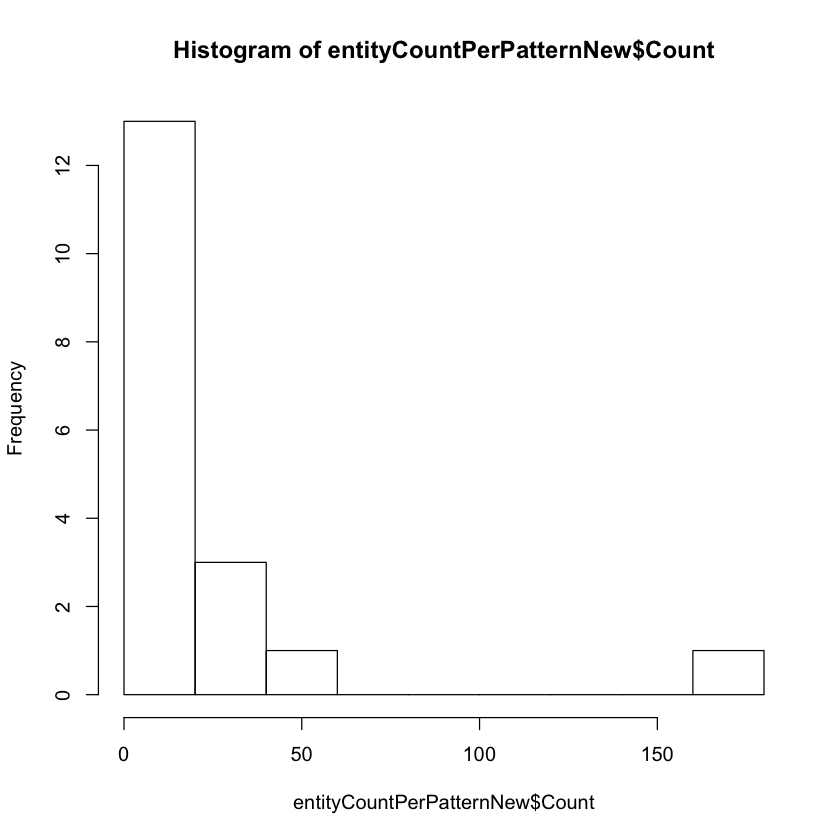

In [14]:
hist(entityCountPerPatternNew$Count)

In [15]:
entityCountPerFileNew=countMatchesPerRow(allEntitiesNew)

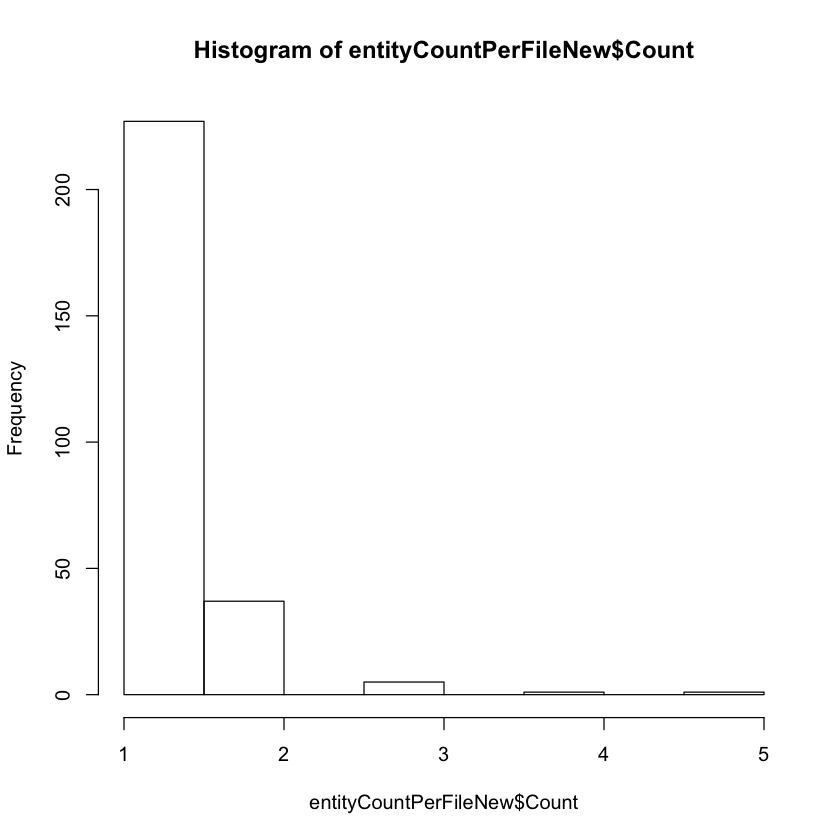

In [16]:
hist(entityCountPerFileNew$Count)

## Write results to a file

In [17]:
write.table(allEntities, file = "allEntitiesNew.csv", row.names = F, na="", sep=";")

ERROR: Error in is.data.frame(x): objeto 'allEntities' no encontrado


## Compare with a gold standard

In [18]:
allMatchesNew = mergeAllMatchesInLists(allEntitiesNew)
head(allMatchesNew)

Files,Matches
cv000_29590.txt,"alan moore , eddie campbell, terry hayes , peter deming , martin childs"
cv001_18431.txt,matthew broderick
cv002_15918.txt,"joe fox , tom hanks"
cv003_11664.txt,shaw
cv004_11636.txt,NULL
cv005_29443.txt,NULL


In [19]:
goldStandard = read.table(file = "goldStandard.csv", quote = "", na.strings=c(""),
                          colClasses="character", sep=";")
allMatchesGold = mergeGoldStandardInLists(goldStandard)
head(allMatchesGold)

Files,Matches
cv000_29590.txt,"alan moore , eddie campbell , moore , campbell , jack , michael jackson , albert , allen hughes , peter godley , robbie coltrane , frederick abberline, johnny depp , abberline , mary kelly , heather graham , terry hayes , rafael yglesias , steve guttenberg , tim burton , marilyn manson , peter deming , martin childs , depp , ians holm , joe gould , richardson , graham"
cv001_18431.txt,"matthew broderick , reese witherspoon , george washington carver, tracy flick , paul , max fischer , bill murray , broderick , witherspoon , jessica campbell , tammy , rooney , campbell , alexander payne , tracy , m"
cv002_15918.txt,"ryan , hanks , tom hanks , joe fox , meg ryan , kathleen kelley, fox , kelley"
cv003_11664.txt,"john williams , steven spielberg, spielberg , williams , martin brody , roy scheider , larry vaughn , murray hamilton , brody , matt hooper , richard dreyfuss, hooper , vaughn , quint , robert shaw , hitchcock , scheider , dreyfuss , shaw , robert redford , paul newman , duddy kravitz , ahab"
cv004_11636.txt,"herb , jackie chan , barry sanders , sanders , jackie , chan , bruce lee , tim allen , lawrence kazdan, john williams , spielberg , george lucas"
cv005_29443.txt,"raoul peck , lumumba , patrice lumumba , eriq ebouaney , helmer peck , peck , pascal bonitzer , patrice , joseph kasa vubu, maka kotto , moise tschombe , pascal nzonzi"


In [20]:
metrics = calculateMetrics(allMatchesNew, allMatchesGold)
metrics

Precision,Recall,Fmeasure
0.7846154,0.01909683,0.03728615


### The precision has decreased a bit compared to the benchmark of 0.79 stablished by some patterns given to us. In absolut numbers, we have reasonably increased the number of matches with the gold standard. The recall measure has been improved to the 2%. 

### The new patterns proposed have given us around 250 new results, being director the keyword which more names find, followed by plays and starring. 